In [ ]:
#conda install pydot graphviz

from __future__ import print_function
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/IFND dataset.csv',encoding = 'unicode_escape', engine ='python')
               

In [ ]:
df.head()

,id,Statement,Label
0,2,"WHO praises India's Aarogya Setu app, says it ...",1
1,3,"In Delhi, Deputy US Secretary of State Stephen...",1
2,4,LAC tensions: China's strategy behind delibera...,1
3,5,India has signed 250 documents on Space cooper...,1
4,6,Tamil Nadu chief minister's mother passes away...,1


In [ ]:
#df['category_id'] = df.category.factorize()[0]

def preprocess_text(sen):
    # Lowercase
    sentence = sen.lower()
        # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Zäöüß]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

df.Statement = df.Statement.apply(preprocess_text)
df[::5000] 

,id,Statement,Label
0,2,who praises india aarogya setu app says it hel...,1
5000,5002,in last stretch dushyant hints at cabinet bert...,1
10000,10002,farmer drove km to ensure daughter appears for...,1
15000,15002,covid impact concern over possible resurgence ...,1
20000,20002,maha boat capsize women drown rescued,1
25000,25002,hear trump sister maryanne trump barry critici...,1
30000,30002,pm modi dalit ministers are parasites says bjp...,1
35000,35002,mamata could skip modi event in bengal today a...,1
40000,40002,no this is not photo of national highway in we...,0
45000,45002,has the lockdown been extended till may here the,0


In [ ]:
# set parameters:
max_features = 20000
maxlen = 400
batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 10

In [ ]:
X = df['Statement'].values
y = df['Label']
y = to_categorical(y, num_classes=2)
y.shape

(56714, 2)

In [ ]:
y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
print('Loading data...')
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)

Loading data...


In [ ]:
x_train = tokenizer.texts_to_sequences(x_train)
x_test  = tokenizer.texts_to_sequences(x_test)

In [ ]:
x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test  =  pad_sequences(x_test, padding='post', maxlen=maxlen)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print('Pad sequences (samples x time)')

37998 train sequences
18716 test sequences
Pad sequences (samples x time)


In [ ]:
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test  =  pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (37998, 400)
x_test shape: (18716, 400)


In [ ]:
import json
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=True))

In [ ]:
print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(2))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Build model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 400, 50)           1000000   
                                                                 
 dropout_4 (Dropout)         (None, 400, 50)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 398, 250)          37750     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 250)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 250)               62750     
                                                                 
 dropout_5 (Dropout)         (None, 250)               0         
                                       

In [ ]:
plot_model(model, to_file='data/CNN-model_plot.png', show_shapes=True, show_layer_names=True, dpi=100)

FileNotFoundError: ignored

In [ ]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=10,
          validation_data=(x_test, y_test),
          callbacks=[EarlyStopping(patience=3, monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
1188/1188 [==============================] - 147s 124ms/step - loss: 0.0222 - accuracy: 0.9886 - val_loss: 0.2878 - val_accuracy: 0.9504
Epoch 2/10
1188/1188 [==============================] - 142s 119ms/step - loss: 0.0195 - accuracy: 0.9896 - val_loss: 0.3419 - val_accuracy: 0.9471
Epoch 3/10
1188/1188 [==============================] - 140s 118ms/step - loss: 0.0183 - accuracy: 0.9898 - val_loss: 0.3036 - val_accuracy: 0.9488
Epoch 4/10
1188/1188 [==============================] - 141s 119ms/step - loss: 0.0170 - accuracy: 0.9904 - val_loss: 0.3597 - val_accuracy: 0.9453


In [ ]:
loss, Accuracy = model.evaluate(x_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", Accuracy)

585/585 [==============================] - 14s 25ms/step - loss: 0.3597 - accuracy: 0.9453
Test Loss: 0.3596647381782532
Test Accuracy: 0.9452874660491943


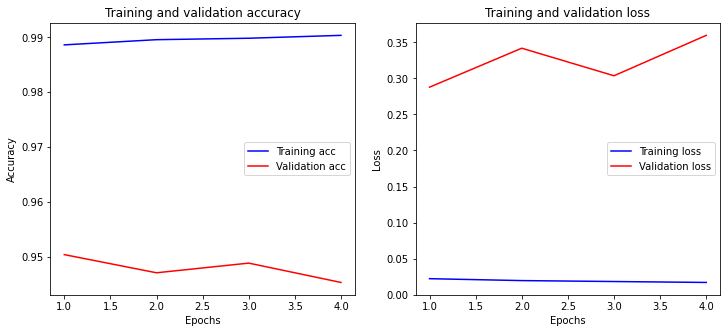

In [ ]:
import matplotlib.pyplot as plt
#plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
plot_history(history)

In [ ]:
model.save('CNN.h5')
model.save_weights('CNN_weights.h5')

In [ ]:
import json
from keras_preprocessing.text import tokenizer_from_json

def load():
    model = load_model('/content/CNN.h5')
    maxlen = 400
    id_to_category = {0:'FALSE', 1:'TRUE'}

    with open('/content/tokenizer.json') as f:
        data = json.load(f)
        tokenizer = tokenizer_from_json(data)
load()

In [ ]:
# Here's how to generate a prediction on individual examples
#text_labels = encoder.classes_ 
id_to_category = {0:'FALSE', 1:'TRUE'}

my_input =["Barack Obama rejects everyone white, including his mother and his grandparents."]

input_sequences = tokenizer.texts_to_sequences(my_input)
input_pad = pad_sequences(input_sequences, padding='post', maxlen=maxlen)

preds = model.predict(input_pad)[0]

pred_classes = np.argsort(preds)[-2:][::-1]

classes = [id_to_category[i] for i in pred_classes]
props   = preds[pred_classes]

result={}
for c, p in zip(classes, props):
    #result.append("{} {:.2f} %".format(c,p*100))
    result[c] = round(p*100,2)
result

{'FALSE': 0.0, 'TRUE': 100.0}